In [22]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression, Lasso, Ridge
from sklearn.metrics import mean_absolute_error
from sklearn.preprocessing import LabelEncoder, StandardScaler 

import shap

## задача 
добиться наилучшего значения метрики MSE, целевая переменна price_doc.

In [150]:
df = pd.read_csv('housing.csv')
df.head(1)

,full_sq,life_sq,floor,max_floor,material,build_year,num_room,kitch_sq,sub_area,area_m,...,metro_min_walk,metro_km_walk,mkad_km,kremlin_km,green_part_1000,prom_part_1000,office_count_1000,trc_count_1000,leisure_count_1000,price_doc
0,38,18.0,1.0,14.0,panel,1971.0,1.0,9.0,Dmitrovskoe,7126815.285,...,27.084184,2.257015,2.442781,14.856442,17.16,10.33,2,4,0,5150000


### Предобработка данных

In [151]:
#размерность данных
df.shape

(8894, 36)

In [152]:
#проверка на пропуски
df.isnull().sum()

full_sq                0
life_sq                0
floor                  0
max_floor              0
material               0
build_year            35
num_room               0
kitch_sq               0
sub_area               0
area_m                 0
green_zone_part        0
indust_part            0
preschool              0
school                 0
healthcare             0
shopping               0
office                 0
radiation              0
detention              0
young                  0
work                   0
elder                  0
0_6_age                0
7_14_age               0
metro_min_avto         0
metro_km_avto          0
metro_min_walk        11
metro_km_walk         11
mkad_km                0
kremlin_km             0
green_part_1000        0
prom_part_1000         0
office_count_1000      0
trc_count_1000         0
leisure_count_1000     0
price_doc              0
dtype: int64

Так как пропусков очень мало, можем их удалить 

In [153]:
#удаление пропусков
df = df.dropna()

In [154]:
#посмотрим на дубликаты
df.duplicated().sum()

42

Дубликаты в данных присутствуют, но их удаление в дальнейшем привело к большему MSE. Поэтому не будем их трогать

<Axes: >

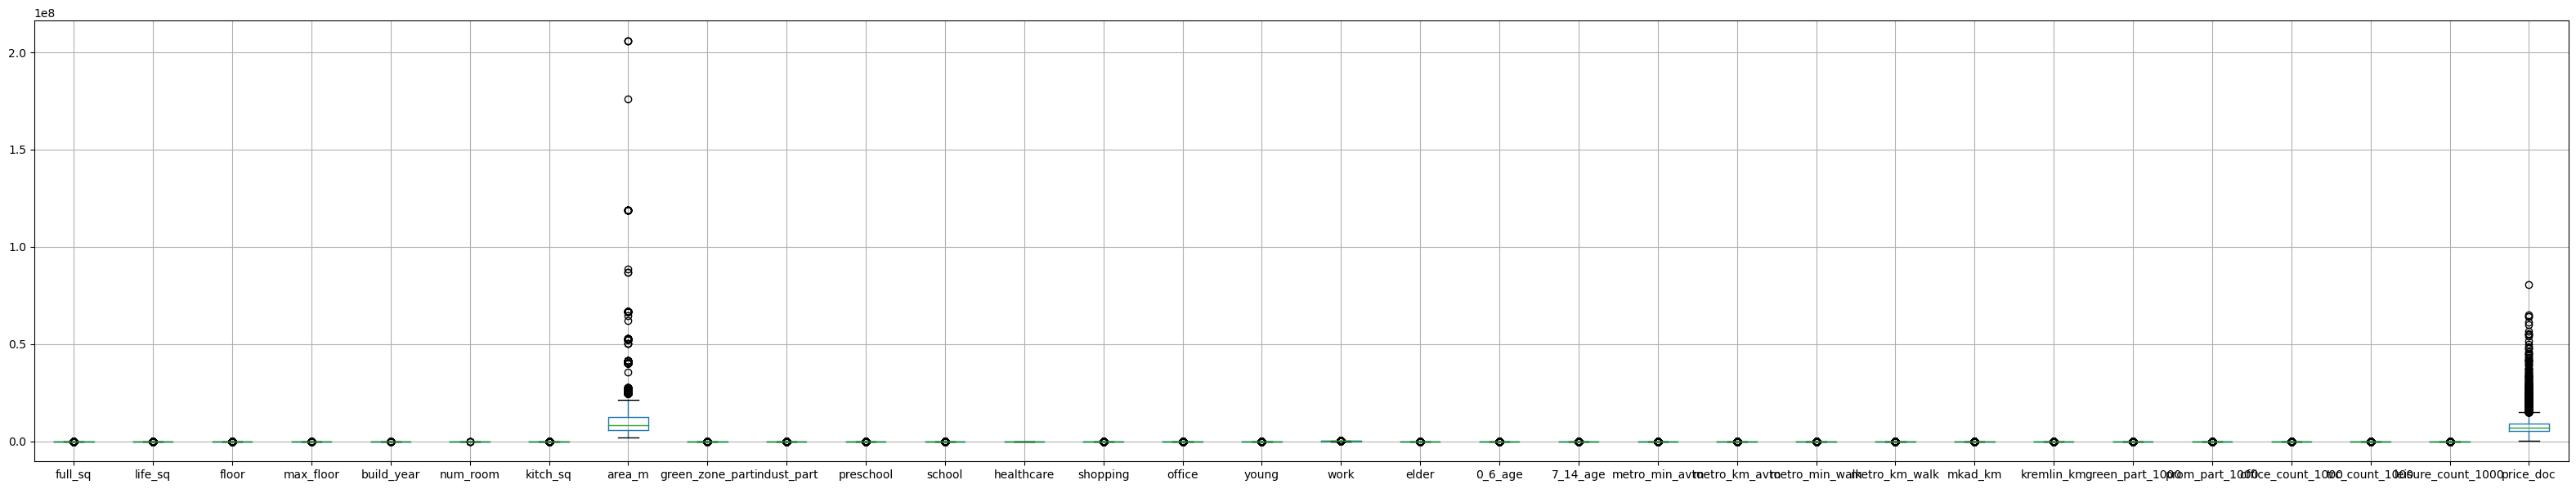

In [155]:
#посмотрим на выбросы
plt.figure(figsize=(40, 7))
df.boxplot()

По графику видно, что в столбце area_m и price_doc содержится большое количество выбросов

In [156]:
#удалим выбросы
for col in ['area_m', 'price_doc']:
    q1 = df[col].quantile(0.25)
    q3 = df[col].quantile(0.75)
    iqr = q3 - q1
    l_bound = q1 - 1.5*iqr
    u_bound = q3 + 1.5*iqr
    df = df[(df[col] >= l_bound) & (df[col] <= u_bound)]

In [157]:
df.shape

(7734, 36)

Данные значительно уменьшились, но выбросы в столбцах негативно сказываются на качестве построения модели, поэтому нужно было их удалить 

Теперь посмотрим на все значения с типом данных object

In [158]:
df.select_dtypes(include=['object']).columns

Index(['material', 'sub_area', 'radiation', 'detention'], dtype='object')

Закодируем их с помощью LabelEncoder

In [159]:
label_en={}
for col in df.select_dtypes(include=['object']).columns:
    le = LabelEncoder()
    df[col] = le.fit_transform(df[col])
    label_en[col] = le 

Вычислим значение Шепли для всех признаков в датасете

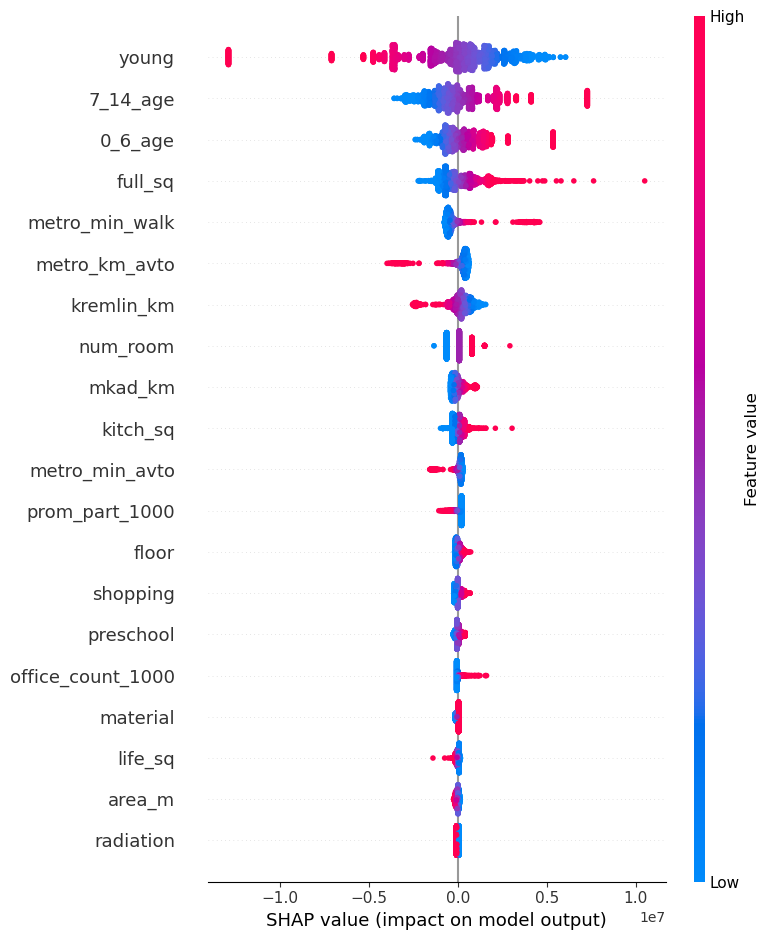

In [160]:
X = df.drop(['price_doc'], axis=1)
y = df[['price_doc']]
train_X, test_X, train_y, test_y = train_test_split(X, y, test_size=0.3, random_state=42)

reg = LinearRegression().fit(train_X, train_y)
explainer = shap.Explainer(reg, train_X)
shap_values = explainer(test_X)
shap.summary_plot(shap_values, test_X)

## Построение моделей 

In [161]:
def price_model(x, y):
    models = {'Linear Regression': LinearRegression(), 'Lasso Regression': Lasso(),'Ridge Regression': Ridge()}
    results = {}
    x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.33, random_state=1)
    sc = StandardScaler()
    
    x_train_scaled = sc.fit_transform(x_train)
    x_test_scaled = sc.fit_transform(x_test)
    for n, model in models.items():
        model.fit(x_train_scaled, y_train)
        y_pred = model.predict(x_test_scaled)
        mse = mean_squared_error(y_test, y_pred)
        results[n] = mse
    results_df = pd.DataFrame(results.values(), index=results.keys(), columns=['MSE'])
    return results_df, y_pred, y_test

In [162]:
#модель на всех данных
x = df.drop(['price_doc'], axis=1)
y = df[['price_doc']]
results_df,  y_pred, y_test = price_model(x, y)
results_df

C:\Anaconda\SDK\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.601e+16, tolerance: 4.897e+12
  model = cd_fast.enet_coordinate_descent(


,MSE
Linear Regression,6.241915e+12
Lasso Regression,6.240781e+12
Ridge Regression,6.241631e+12


In [167]:
#модель на данных с учетом значения Шепли
x = df[['young', '7_14_age', 'full_sq', '0_6_age', 'num_room', 
        'kremlin_km', 'kitch_sq']]
y = df[['price_doc']]
results_df,  y_pred, y_test = price_model(x, y)
results_df

C:\Anaconda\SDK\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.697e+16, tolerance: 4.897e+12
  model = cd_fast.enet_coordinate_descent(


,MSE
Linear Regression,6.330281e+12
Lasso Regression,6.345494e+12
Ridge Regression,6.341144e+12


Мною было проверены комбинации признаков и все они были хуже чем результат обучения на всех данных

Таким образом, наилучший результат MSE был получен с регуляризация Lasso на всем наборе данных